# DASC521: Home Work 1
## Sina Dadmand


# Generating random data points based on HW:

### Importing libraries

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import math


### Parameter definition

In [98]:
mu1 = [0, 2.5]
mu2 = [-2.5, -2]
mu3 = [2.5, -2]

cov1 = [[3.2, 0], [0, 1.2]]
cov2 = [[1.2, 0.8], [0.8, 1.2]]
cov3 = [[1.2, -0.8], [-0.8, 1.2]]

N1 = 120
N2 = 80
N3 = 100

### Generating data

In [99]:

x1 = np.random.multivariate_normal(mu1, cov1, size=N1)
x2 = np.random.multivariate_normal(mu2, cov2, size=N2)
x3 = np.random.multivariate_normal(mu3, cov3, size=N3)

X = np.concatenate((x1, x2, x3))

y = np.concatenate((np.repeat(1, N1), np.repeat(2, N2), np.repeat(3, N3)))

df = np.append(X,y[:, None], axis=1)

### Visualizing the random 

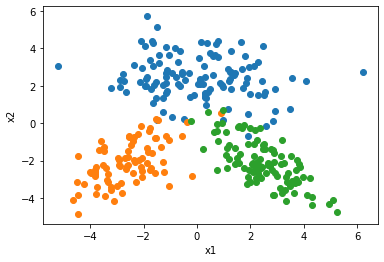

In [100]:

plt.plot(df[df[:,2]==1].T[0], df[df[:,2]==1].T[1], 'o')
plt.plot(df[df[:,2]==2].T[0], df[df[:,2]==2].T[1], 'o')
plt.plot(df[df[:,2]==3].T[0], df[df[:,2]==3].T[1], 'o')

plt.axis()
plt.xlabel("x1")
plt.ylabel("x2")

plt.show()

### Sample means:

In [101]:
# get x and y values
x1 = df[:,0]
x2 = df[:,1]
y = df[:,2].astype(int)

# get number of classes and number of samples
K = np.max(y)
N = df.shape[0]

# calculate sample means
sample_means1 = [np.mean(x1[y == (c + 1)]) for c in range(K)]
sample_means2 = [np.mean(x2[y == (c + 1)]) for c in range(K)]
sample_means = np.column_stack((sample_means1 ,sample_means2))

print(sample_means)

[[ 0.04032901  2.41023923]
 [-2.58825276 -2.08679107]
 [ 2.46821704 -2.11649178]]


### Sample variance and covariances:

In [102]:
# calculate sample variance and covariances
varx1 = [(np.mean((x1[y == (c + 1)] - sample_means1[c])**2)) for c in range(K)]
varx2 = [(np.mean((x2[y == (c + 1)] - sample_means2[c])**2)) for c in range(K)]
covar_x1_2 = [(np.mean((x1[y == (c + 1)] - sample_means1[c])*(x2[y == (c + 1)] - sample_means2[c]))) for c in range(K)]

sample_covariances = np.array([[
                       [varx1[0],      covar_x1_2[0]],
                       [covar_x1_2[0], varx2[0]]],
                      
                       [[varx1[1],     covar_x1_2[1]],
                       [covar_x1_2[1], varx2[1]]],
                      
                       [[varx1[2],     covar_x1_2[2]],
                       [covar_x1_2[2], varx2[2]]]
                     ])

print(sample_covariances)

[[[ 3.17605118 -0.36284781]
  [-0.36284781  1.33879818]]

 [[ 1.20264422  0.7259267 ]
  [ 0.7259267   1.32059292]]

 [[ 1.18605598 -0.90876384]
  [-0.90876384  1.41980324]]]


### class priors

In [103]:
# calculate prior probabilities
class_priors = [np.mean(y == (c + 1)) for c in range(K)]

print(class_priors)

[0.4, 0.26666666666666666, 0.3333333333333333]


# Confusion matrix

In [104]:
# defining the variables
Wc = np.stack([-0.5*np.linalg.inv(sample_covariances[c])for c in range(K)])
wc = np.stack([np.linalg.inv(sample_covariances[c])@sample_means[c] for c in range(K)])
wc0 = np.stack([-0.5*(sample_means[c].T)@np.linalg.inv(sample_covariances[c])@(sample_means[c])-0.5*np.log(np.linalg.det(sample_covariances[c]))+np.log(class_priors[c]) for c in range(K)])

In [105]:
# initial values for gc(x) function
gc_x = np.zeros((N,K))

# filling the gc_x function
for j in range(K):
    cnt = 0
    for i in range(N):
            x = X[i].T
            gc_x[cnt,j] = x.T@Wc[j]@x+wc[j].T@x+wc0[j]
            cnt +=1

In [106]:
y_predicted = np.argmax(gc_x, axis = 1) + 1 # +1 to conver indedx value to y code
confusion_matrix = pd.crosstab(y_predicted, y, rownames = ['y_pred'], colnames = ['y_truth'])
print(confusion_matrix)

y_truth    1   2   3
y_pred              
1        115   2   3
2          2  78   0
3          3   0  97


# Decision boundaries

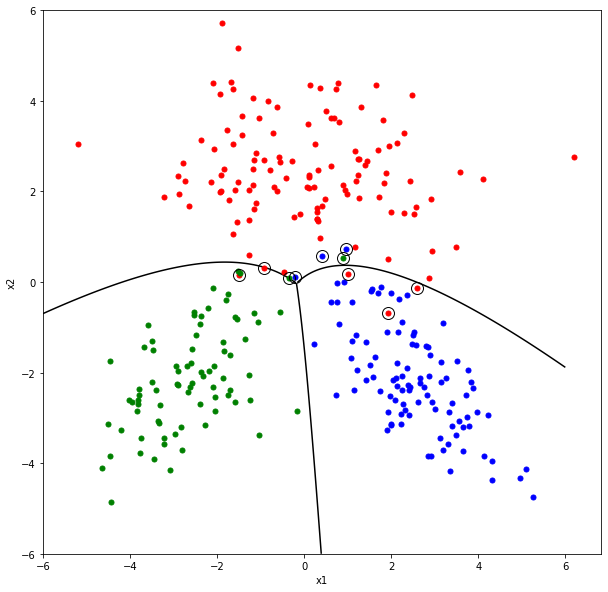

In [110]:
# evaluate discriminant function on a grid
x1_interval = np.linspace(-6, +6, 500)
x2_interval = np.linspace(-6, +6, 500)
x1_grid, x2_grid = np.meshgrid(x1_interval, x2_interval)

discriminant_values = np.zeros((len(x1_interval), len(x2_interval), K))


for c in range(K):
    for i in range(x1_grid.shape[0]):
        for j in range(x2_grid.shape[0]):
            x = np.array([x1_grid[i][j], x2_grid[i][j]]).reshape(2,1)
            discriminant_values[i,j,c] = x.T@Wc[c]@x+wc[c].T@x+wc0[c]
            
A = discriminant_values[:,:,0]
B = discriminant_values[:,:,1]
C = discriminant_values[:,:,2]
A[(A < B) & (A < C)] = np.nan
B[(B < A) & (B < C)] = np.nan
C[(C < A) & (C < B)] = np.nan
discriminant_values[:,:,0] = A
discriminant_values[:,:,1] = B
discriminant_values[:,:,2] = C

plt.figure(figsize = (10, 10))
plt.plot(X[y == 1, 0], X[y == 1, 1], "r.", markersize = 10)
plt.plot(X[y == 2, 0], X[y == 2, 1], "g.", markersize = 10)
plt.plot(X[y == 3, 0], X[y == 3, 1], "b.", markersize = 10)
plt.plot(X[y_predicted != y, 0], X[y_predicted != y, 1], "ko", markersize = 12, fillstyle = "none")
plt.contour(x1_grid, x2_grid, discriminant_values[:,:,0] - discriminant_values[:,:,1], levels = 0, colors = "k")
plt.contour(x1_grid, x2_grid, discriminant_values[:,:,0] - discriminant_values[:,:,2], levels = 0, colors = "k")
plt.contour(x1_grid, x2_grid, discriminant_values[:,:,1] - discriminant_values[:,:,2], levels = 0, colors = "k")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()